Original data available at:

https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
%matplotlib inline
%load_ext autotime
import sys
sys.path.append('../src/')

In [219]:
from typing import Tuple, Sequence, Dict, Callable, Any, List, Pattern, Union, Iterable, overload
from tqdm.autonotebook import tqdm

from functools import partial
import nltk
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer
from nltk.tokenize.stanford import StanfordTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag_sents, pos_tag
import re
import datetime

import zipfile

from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Lock
import random, statistics
import toolz as tz
import toolz.curried as tzc

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing as pp
from sklearn import (feature_extraction, decomposition, linear_model, svm, model_selection, metrics)
from sklearn.pipeline import make_pipeline, make_union
from pattern import en as pattern_en
from pattern.web import plaintext
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import spacy

from utils.preprocessing import (create_corpus_processor, filter_stopwords, clean_html, QUOTES_PATTERN, PARENTHESIS_PATTERN,
                                get_curated_english_contractions, filter_stopwords, RegexpReplacer, CorpusNormalizer)
from utils.nn import (ScoreScaler, create_embedding_matrix, load_word_vectors, predict_scores)
from utils.evaluate import evaluate_prediction, save_report

sns.set()

time: 6.73 ms


In [3]:
DATADIR = Path('../data/')
MODELS_DIR = Path('../models/')

TMPDIR = Path('../tmp')
ARTEFACT_DIR = Path('../artefacts/')
REPORTS_DIR = Path('../reports/')

TRAIN_DATASET_FILE = DATADIR / 'Reviews-train.csv.gzip'
TEST_DATASET_FILE = DATADIR / 'Reviews-test.csv.gzip'

time: 1.41 ms


### Create Train/Test split
We reserve 10% of the dataset for testing.

In [4]:

if not (TRAIN_DATASET_FILE.exists() and TEST_DATASET_FILE.exists()):
    print('Building train/test split.')
    rawdataset = pd.read_csv(DATADIR / 'Reviews.csv', index_col=0)
    train, test = train_test_split(rawdataset, test_size=0.10)
    print(f'shape of training data: {train.shape}')
    train.to_csv(TRAIN_DATASET_FILE, compression='gzip')
    print(f'shape of testing data: {test.shape}')
    test.to_csv(TEST_DATASET_FILE, compression='gzip')
else:
    print('train/test split exists. Loading training data.')
    rawdataset = pd.read_csv(TRAIN_DATASET_FILE, compression='gzip', index_col=0)
    print(f'shape of dataset data: {rawdataset.shape}')

train/test split exists. Loading training data.
shape of dataset data: (511608, 9)
time: 4.84 s


## Exploratory Data Analysis

In [7]:
rawdataset.sample(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
63588,B002IEZJMA,AC4XV78EJG1QB,Anne,0,1,5,1340582400,Better than a Doubleshot,My husband loves espresso. We have a bialetti...
439596,B000ZSX4D2,A1X1CEGHTHMBL1,jjceo,1,1,5,1339372800,One of my very favorite flavors!,I love all of the Blue Diamond Almond flavors ...
85320,B0014H18L8,A38X5Z2BZ0MMQJ,Spuds Benson,1,1,5,1350172800,Discovering Sardines? Try these!,Mild flavor. Excellent quality. Too many sardi...


time: 37.3 ms


In [8]:
rawdataset.describe(include=['O'])

,ProductId,UserId,ProfileName,Summary,Text
count,511608,511608,511594,511582,511608
unique,71053,238161,203824,271921,359839
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",Delicious!,"This review will make me sound really stupid, ..."
freq,827,410,413,2239,185


time: 2 s


In [9]:
rawdataset.describe(exclude=['O'])

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,511608.000000,511608.000000,511608.000000,5.116080e+05
mean,1.746491,2.232741,4.183232,1.296241e+09
std,7.762385,8.413478,1.310201,4.803743e+07
min,0.000000,0.000000,1.000000,9.393408e+08
25%,0.000000,0.000000,4.000000,1.271290e+09
50%,0.000000,1.000000,5.000000,1.311120e+09
75%,2.000000,2.000000,5.000000,1.332720e+09
max,866.000000,923.000000,5.000000,1.351210e+09


time: 146 ms


This analysis will focus on predicting the score of the review. Let's start by dropping the columns we're not going to use.
Note that this dataset could be used to train a recommendation engine thanks to the ProductId/UserId provided.

In [10]:
eda_dataset = rawdataset.drop(['ProductId', 'UserId', 'Time', 'ProfileName'], axis=1)
eda_dataset['SummaryLength'] = eda_dataset['Summary'].str.len()
eda_dataset['TextLength'] = eda_dataset['Text'].str.len()

time: 342 ms


In [11]:
eda_dataset[['Score', 'Summary']].sample(10)

,Score,Summary
Id,,
217392,5,Excellent treats
467449,5,grapefruit in a can YUM
150849,1,NOT Haribo quality--this stuff is horrible!
109958,5,GREEN MTN COFFEE ROCKS!
453425,5,Best coffee and most economical way to get K-cups
176720,5,LOVE THIS STUFF !!!
38070,4,Elegant
380900,5,Yum-O!
105554,5,Addicting!


time: 51 ms


In [12]:
eda_dataset[['Score', 'Text']].sample(10)

,Score,Text
Id,,
103123,5,hazelnut and irish creme are my 2 favs from to...
545111,5,These seeds have to be the best bang for your ...
302032,5,I think the dispensers are great. I like that...
227003,5,My favorites are the Latte and Espresso candie...
474276,5,This is a great product and is very convenient...
207288,5,this is the first time i have even heard of st...
354819,1,The regular cola flavor has a terrible diet ta...
135924,5,We have always used Anchor bar sauce for our w...
215036,5,Like the other reviewers we love the taste of ...


time: 41.2 ms


In [13]:
eda_dataset_by_scores = eda_dataset.groupby('Score')

time: 1.16 ms


In [14]:
eda_dataset_by_scores[['SummaryLength', 'TextLength']].describe()

SummaryLength                                                      \
              count       mean        std  min   25%   50%   75%    max   
Score                                                                     
1           46997.0  24.466030  15.302695  1.0  13.0  21.0  32.0  128.0   
2           26779.0  24.889391  14.601783  1.0  14.0  22.0  33.0  128.0   
3           38443.0  26.086102  15.158867  1.0  15.0  23.0  34.0  127.0   
4           72578.0  24.839290  14.754415  1.0  14.0  22.0  33.0  128.0   
5          326785.0  22.552235  13.366505  1.0  13.0  20.0  29.0  128.0   

      TextLength                                                              
           count        mean         std   min    25%    50%    75%      max  
Score                                                                         
1        46997.0  478.542184  520.123653  12.0  202.0  339.0  564.0  11861.0  
2        26803.0  490.476775  456.281301  33.0  212.0  358.0  606.0   9295.0  
3        38445.0  520.681129  512.352307  32.0  214.0  373.0  656.0  21409.0  
4        72578.0  496.934030  486.023788  35.0  196.0  347.0  623.0  12518.0  
5       326785.0  402.671197  411.328065  18.0  170.0  277.0  481.0  16952.0

time: 176 ms


Good reviews are shorter on average.

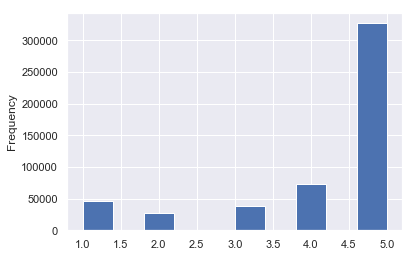

time: 276 ms


In [15]:
eda_dataset['Score'].plot('hist')

Perfect scores are overreppresented. We're in presence of a fairly imbalanced dataset.

In [16]:
def get_sample_reviews(dataset, label=None, n=5):
    for _ in range(n):
        text = dataset['Text'].sample().values[0]
        print('\n')
        print('-' * 100)
        if label:
            print(label)
        print(text)
        

time: 1.26 ms


In [17]:
for i in range(1, 6):
    print('\n')
    print('=' * 100)
    print('Score: ', i)
    print('=' * 100)
    get_sample_reviews(eda_dataset_by_scores.get_group(i), n=2)




Score:  1


----------------------------------------------------------------------------------------------------
In addition to the loads of salt, almost each piece no matter how small seems to cotain fiberous stuff that does not get soft no matter how much you chew it.  I've tried many brands of jerky and I can't say I ever noticed this problem to this extent.


----------------------------------------------------------------------------------------------------
I should've known better than to expect fresh coffee from a warehouse buy. There was no expiration date on the bags. I knew as soon as I smelled it that it was undrinkable. I had to throw it away.


Score:  2


----------------------------------------------------------------------------------------------------
I bought a box of these snack packs to take with me when travelling.  My hope was that they would give me a nice protein boost once or twice during the day.  While they might have given me some protein, they also came w

Observations:
* html tags are still present.
* Some english contractions still present.

In [18]:
eda_dataset['Text'] = eda_dataset['Text'].apply(plaintext)

time: 51.7 s


In [19]:
get_sample_reviews(eda_dataset, n=2)



----------------------------------------------------------------------------------------------------
The package arrived with all the cans inside of a cardboard tray that was shrink wrapped. There was no damage to the cans and they tasted just fine.

As far as V-8 itself...

I enjoy using V-8 as a meal replacement (replacing a greasy breakfast). Think of it as tomato soup with a little less flavoring. It was an acquired taste for me that I have since come to enjoy. If you find that the original is a bit on the bland side, you can try the spicy flavor as a nice alternative. The only drawback is that spicy has a bit more sodium.


----------------------------------------------------------------------------------------------------
This cracker curbs appetite like no other. I have it in the morning with some low fat cheese on it, in the afternoon with some peanut butter and jelly on it and then in the evening with some cream cheese and salmon on it. I make sure to drink plenty of water t

### EDA - Preprocessing

We're going to tokenize and stem the dataset to have a look at the distribution of tokens by scores.
Note that we do not use spacy for the sake of the exercise.

A first pass over the data reveal that stopwords and punctuation are significantly poluting the dataset. We'll remove them first

In [20]:

class DocumentStemmer:
    def __init__(self, stopwords, lower=True):
        self._stemmer = PorterStemmer()
        self._stopwords = stopwords
        self._lower = lower
        sent_tokenizer = PunktSentenceTokenizer()
        word_tokenizer = TreebankWordTokenizer()
        self._tokenize_text = tzc.compose(tzc.mapcat(word_tokenizer.tokenize), sent_tokenizer.tokenize)
        
    def stem_document(self, doc):
        if self._lower:
            doc = doc.lower()
        tokens = self._tokenize_text(doc)
        stems = [self._stemmer.stem(w) for w in tokens if w not in self._stopwords]
        return stems
        

time: 2.08 ms


In [21]:
STOPWORDS = {'.', ',', "''", '``', '(', ')'}.union(stopwords.words('english'))

time: 10.6 ms


In [22]:

doc_stemmer = DocumentStemmer(STOPWORDS)

time: 899 µs


In [23]:
with ProcessPoolExecutor() as executor:
    stems = list(executor.map(doc_stemmer.stem_document, eda_dataset['Text'], chunksize=1000))
    

time: 3min 9s


In [24]:
eda_dataset['Stems'] = stems

time: 469 ms


In [25]:
eda_dataset_by_scores = eda_dataset.groupby('Score')

time: 215 ms


In [33]:
def show_most_common(counter, title=None, n=25):
    most_common = reversed(counter.most_common(n))
    k, v = zip(*most_common)
#     fig = plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.barh(k, v);



time: 1.35 ms


In [27]:
counters = {
    name: Counter(tz.concat(df['Stems']))
    for name, df in eda_dataset_by_scores
}


time: 3.13 s


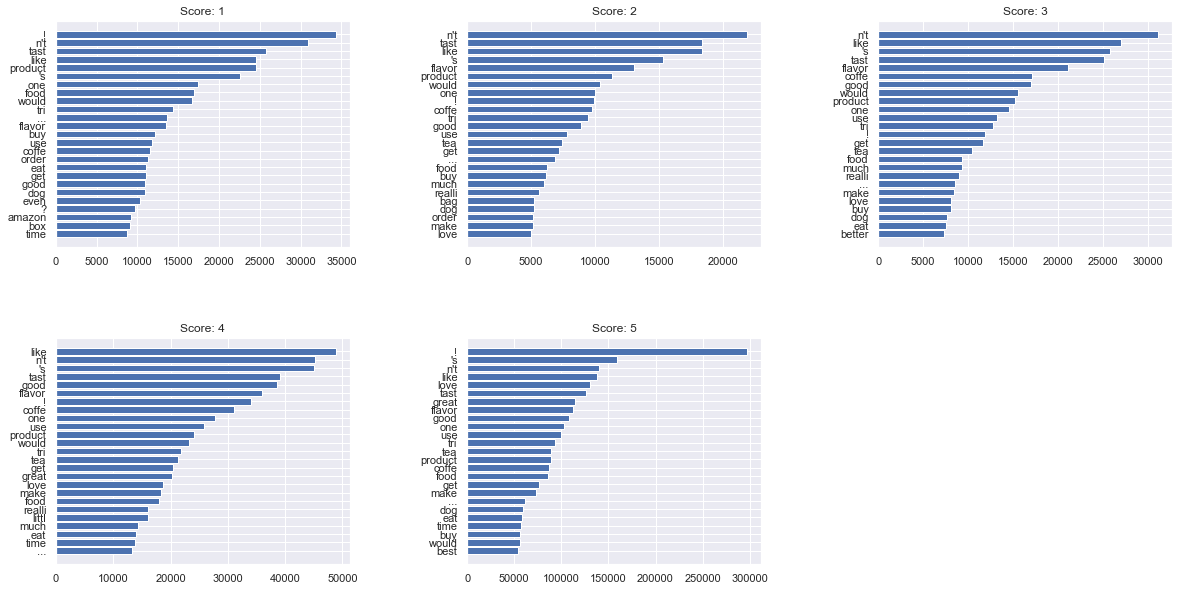

time: 1.55 s


In [36]:
#TODO: Create word cloud and attempt to identify some pattern.
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (score, counter) in enumerate(counters.items()):
    ax = fig.add_subplot(2, 3, i+1)
    show_most_common(counter, f'Score: {score}')

## Raw Dataset

In [10]:
features_train, features_devtest, scores_train, scores_devtest = train_test_split(rawdataset.drop('Score', axis=1), 
                                                                                  rawdataset['Score'], 
                                                                                  test_size=0.25, stratify=rawdataset['Score'])
X = features_train['Text']
X_devtest = features_devtest['Text']
print(f'train: {features_train.shape}\ndevtest: {features_devtest.shape}')

train: (383706, 8)
devtest: (127902, 8)
time: 566 ms


In [11]:
X_sampled, _, y_sampled, _ = train_test_split(X, scores_train, train_size=0.5, stratify=scores_train) 
print(f'sample size: {X_sampled.shape}')

sample size: (191853,)
time: 204 ms


## Modelling

### Modelling - Baseline Model

We start with a baseline model applying LSA to the dataset with no additional features.
We'll test a few different model types with this simple feature set.

In [45]:
def make_baseline(estimator):
    baseline = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8),
        estimator
    )
    
def evaluate_baseline(baseline, X, y, X_test, y_test, label=None):
    tranforms = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8)
    )
    X_tf = tranforms.fit_transform(X)
    
    print(f'training {baseline} done.')
    print('evaluating...')
    y_pred = baseline.predict(X_test)
    report = evaluate_prediction(y_test, y_pred)
    if label:
        label = f'baseline-{label}'
    else:
        label = 'baseline'
    save_report(report, REPORTS_DIR, label)
    return baseline, report


time: 4.3 ms


In [46]:
baselines = {
    'logit-ovr': linear_model.LogisticRegression(solver='saga', multi_class='ovr', n_jobs=-1, max_iter=250),
    'logit-multinomial': linear_model.LogisticRegression(solver='saga', multi_class='multinomial', n_jobs=-1, max_iter=250),
}

time: 3.84 ms


In [209]:
def evaluate_baseline(estimator, feature_extractor, X_train, y_train, X_test, y_test, label=None):
    X = feature_extractor.transform(X_train)
    estimator.fit(X, y_train)

    baseline = make_pipeline(*feature_extractor.named_steps.values(), estimator)
    
    print(f'fitting {label or baseline} done. evaluating...')
    
    y_pred = baseline.predict(X_test)
    report = evaluate_prediction(y_test, y_pred)
    if label:
        label = f'baseline-{label}'
    else:
        label = 'baseline'
    save_report(report, REPORTS_DIR, label)
    return baseline, report


def evaluate_baselines(baselines, X_train, y_train, X_test, y_test):
    lsa = make_pipeline(
        feature_extraction.text.TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2)),
        decomposition.TruncatedSVD(n_components=300, n_iter=8)
    )
    lsa.fit(X_train)
    print('feature extraction done.')
    
    with ProcessPoolExecutor() as executor:
        future_to_labels = {
            executor.submit(evaluate_baseline, baseline, lsa, X_train, y_train, X_test, y_test, label): label
            for label, baseline in baselines.items()
        }
    
    results = {}
    for future in as_completed(future_to_labels):
        label = future_to_labels[future]
        result = future.result()
        print(result)
        if isinstance(result, tuple):
            model, report = result
            result[label] = {'model': model, 'report': report}
        else:
            print(f'issue with {label}')

    return results

    



feature extraction done.
fitting logit-multinomial done. evaluating...
AUROC: 0.614
MCC: 0.365
              precision    recall  f1-score   support

           1       0.55      0.54      0.54     11749
           2       0.33      0.05      0.09      6701
           3       0.36      0.14      0.20      9611
           4       0.46      0.14      0.22     18145
           5       0.74      0.96      0.84     81696

   micro avg       0.70      0.70      0.70    127902
   macro avg       0.49      0.37      0.38    127902
weighted avg       0.63      0.70      0.63    127902



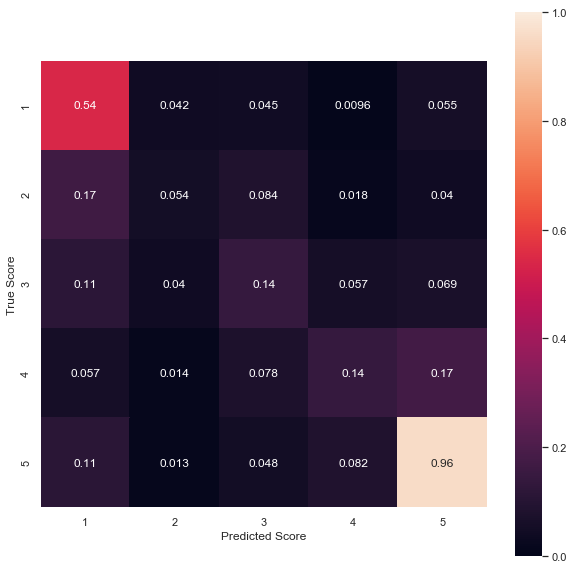

fitting logit-ovr done. evaluating...
AUROC: 0.601
MCC: 0.347
              precision    recall  f1-score   support

           1       0.56      0.50      0.53     11749
           2       0.36      0.03      0.05      6701
           3       0.37      0.10      0.16      9611
           4       0.42      0.14      0.21     18145
           5       0.73      0.97      0.83     81696

   micro avg       0.69      0.69      0.69    127902
   macro avg       0.49      0.35      0.35    127902
weighted avg       0.62      0.69      0.62    127902



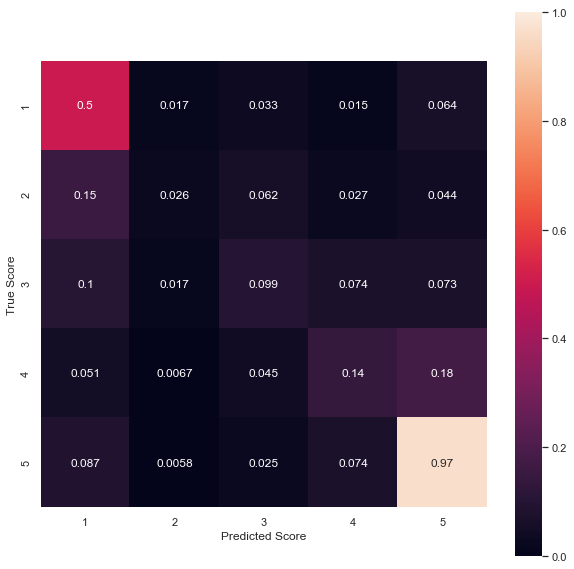

(Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smoot...penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))]), {'auroc': 0.6005091256480368, 'f1score': 0.3542407767902014, 'normalized_confusion_matrix': [[0.49655289811898884, 0.016713923295030592, 0.03267089792945583, 0.014549462661890328, 0.06395661966314141], [0.1539705506851647, 0.0261155051484853, 0.061596087816044115, 0.027280242491044365, 0.04443301997649824], [0.10324282917695123, 0.016564691837039246, 0.09863697846217875, 0.07406999173325986, 0.07338180571876224], [0.05072772150821347, 0.006715415609610506, 0.04536468629695141, 0.1393772389087903, 0.17796464943204074], [0.08690101285215764, 0.005820026861662438

TypeError: 'tuple' object does not support item assignment

In [210]:
results = evaluate_baselines(baselines, X_sampled, y_sampled, X_devtest, scores_devtest)

## Corpus Preparation

In [12]:
ENGLISH_CONTRACTIONS = get_curated_english_contractions(ARTEFACT_DIR / 'curated_contractions.csv')
STANFORD_POSTAGGER_JAR = str(ARTEFACT_DIR / 'stanford-postagger/stanford-postagger.jar')
STANFORD_POSTAGGER_OPTIONS = dict(normalizeParentheses=False, normalizeFractions=True, normalizeOtherBrackets=False, splitHyphenated=True)


quote_remover = RegexpReplacer(QUOTES_PATTERN)
hyphen_replacer = RegexpReplacer([('-', ' ')])
parenthesis_remover = RegexpReplacer(PARENTHESIS_PATTERN)
contraction_replacer = RegexpReplacer(ENGLISH_CONTRACTIONS)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = TreebankWordTokenizer()
stanford_tokenizer = StanfordTokenizer(STANFORD_POSTAGGER_JAR, options=STANFORD_POSTAGGER_OPTIONS)
tokenize_text = tzc.compose(tzc.mapcat(stanford_tokenizer.tokenize), sent_tokenizer.tokenize)
lower_tokens = tzc.map(str.lower)

time: 2.94 ms


In [13]:
def spellcheck_token(token: str) -> str:
    if token in word_vectors:
        return token
    
    suggestions = pattern_en.suggest(token)
    correction: str
    if suggestions[0][1] >= 0.95:
        correction = suggestions[0][0]
    else:
        correction = token
        
    return token

def strip_token(token: str) -> str:
    return token.strip('.*_-\'\"')

def split_token(token: str) -> str:
    '''
    Splits a token in its part based on a separation character.
    '''
    patterns = ['.', '-', '*', '/', '\\']
    for pattern in patterns:
        token.split()
        
def spacy_tokenize(doc):
    return [token.text for token in nlp(doc)]

def generate_sentences(indexed_documents):
    for doc, i in indexed_documents:
        for sent in doc.sents:
            yield sent.text
            
def generate_texts(indexed_documents):
    for doc, i in indexed_documents:
        yield doc.text
            
def save_sentences(path: Union[str, Path], documents):
    '''
    Writes sentes to file to make embedding model training faster.
    '''
    with open(path, 'wt') as f:
        for doc in documents:
            for sent in doc.sents:
                f.write(sent.text)
                f.write('\n')

            
def train_fasttext(corpus_file, size, total_words, epochs, window=5):
    vector_model = FastText(size=300, window=window, min_count=1, sg=1)
    vector_model.build_vocab(corpus_file=corpus_file)
    vector_model.train(corpus_file=corpus_file, 
                       total_examples=vector_model.corpus_count, 
                       total_words=total_words, 
                       epochs=epochs)
    return vector_model


def count_words(indexed_documents):
    return np.sum(len(doc) for doc, i in indexed_documents)
    
    
def save_documents(path, indexed_documents):
    '''
    Archive the serialized document in a zip file.
    '''
    with zipfile.ZipFile(path, 'w', compression=zipfile.ZIP_DEFLATED) as archive:
        for i, (doc, index) in enumerate(indexed_documents):
            doc.tensor = None
            data = doc.to_bytes()
            archive.writestr(f'{index}.pickle', data)
    
    
spellcheck_tokens = tzc.map(spellcheck_token)
strip_tokens = tzc.map(strip_token)

time: 5.22 ms


### Normalization and Parsing

In [16]:
normalizer = CorpusNormalizer(contraction_replacer, clean_html)
nlp = spacy.load('en_core_web_sm', disable=('ner'))
batch_size = 2000


time: 149 ms


In [19]:

def parse_corpus(corpus, index=None, path=None, batch_size=1000):
    print('parsing training set...')
    if index is None:
        index = range(len(corpus))
        
    normalized_corpus = normalizer.transform(corpus)
    texts = zip(normalized_corpus, index)
    indexed_parsed_corpus = [doc for doc in tqdm(nlp.pipe(texts, as_tuples=True, batch_size=batch_size), total=len(corpus))]
    print('done.')

    if path:
        print(f'saving corpus to {path}')
        save_documents(path, indexed_parsed_corpus)
        print('done.')

    return indexed_parsed_corpus

time: 2.35 ms


#### Training Corpus

In [20]:
train_save_path = ARTEFACT_DIR / 'train_corpus.zip'
parsed_train_corpus = parse_corpus(X, X.index, train_save_path, batch_size)
word_count = count_words(parsed_train_corpus)
print(f'{word_count} word in corpus')

parsing training set...


done.
saving corpus to ../artefacts/train_corpus.zip
done.
35833002 word in corpus
time: 46min 13s


In [22]:
print('saving training sentences to disk...')
corpus_file = TMPDIR / 'train_sentences.txt'
save_sentences(corpus_file, tz.map(tzc.get(0), parsed_train_corpus))
print('done.')

saving training sentences to disk...
done.
time: 28.4 s


#### Validation Corpus

In [24]:
devtest_save_path = ARTEFACT_DIR / 'devtest_corpus.zip'

parsed_devtest_corpus = parse_corpus(X_devtest, X_devtest.index, devtest_save_path, batch_size)

parsing training set...


done.
saving corpus to ../artefacts/devtest_corpus.zip
done.
time: 15min 26s


### Training Fasttext

In [25]:
size = 300
epochs = 10
print(f'training FastText-{size} for {epochs} epochs')
vector_model = train_fasttext(corpus_file.as_posix(), total_words=word_count, size=size, window=5, epochs=epochs)
print('done')

print('saving FastText model to disk...')
vector_model_file = (MODELS_DIR / f'fasttext/fasttext-{size}.model').as_posix()
vector_model.save(vector_model_file)
print('done.')

training FastText-300 for 10 epochs


W0511 00:05:48.300411 140735669322624 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


done
saving FastText model to disk...


W0511 00:41:33.470665 140735669322624 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


done.
time: 36min 14s


## Modelling - DNN

In [26]:
!ls $DATADIR

Reviews-test.csv.gzip        raw_contractions.csv
Reviews-train.csv.gzip       raw_contractions.txt
Reviews.csv                  sampleSubmission.csv
amazon-fine-food-reviews.zip testData.tsv
hashes.txt                   unlabeledTrainData.tsv
labeledTrainData.tsv
time: 253 ms


In [27]:
tokenizer = Tokenizer(oov_token='<UNK>', lower=True)

time: 3.45 ms


In [29]:
tokenizer.fit_on_texts(generate_texts(parsed_train_corpus))

time: 1min 20s


In [30]:
'<UNK>' in vector_model.wv

True

time: 23.2 ms


In [31]:
embedding_matrix = create_embedding_matrix(tokenizer.word_index, vector_model.wv)

time: 13.1 s


In [32]:
miss = embedding_matrix.sum(axis=1) == 0
miss_idx = np.where(miss)[0]
embedding_coverage = 1 - miss.sum() / embedding_matrix.shape[0]
print(f'embedding coverage: {embedding_coverage}')

embedding coverage: 0.9999906332836898
time: 83.5 ms


In [33]:
missed_words = [tokenizer.index_word[i] for i in miss_idx[1:]]
len(missed_words)

0

time: 4.42 ms


In [34]:
# ".26.4".strip('\'.')

time: 728 µs


In [222]:
MODELS_DIR.mkdir?

time: 5.41 ms


Signature: MODELS_DIR.mkdir(mode=511, parents=False, exist_ok=False)
Docstring: Create a new directory at this given path.
File:      ~/.pyenv/versions/3.7.0/lib/python3.7/pathlib.py
Type:      method


In [223]:
def get_callbacks(label: str) -> List[Callback]:
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=7, 
                                   verbose=0, 
                                   mode='auto', 
                                   restore_best_weights=True)
    
    checkpoint_path = MODELS_DIR / label / 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    if not checkpoint_path.parent.exists():
        checkpoint_path.parent.mkdir()
        
    checkpoint = ModelCheckpoint(checkpoint_path.as_posix(), period=3, save_best_only=True, save_weights_only=True)
    
    reduce_lr = ReduceLROnPlateau(patience=5)
    
    log_path = MODELS_DIR / label / 'logs/fit' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if not log_path.exists():
        log_path.mkdir(parents=True)
        
    tensorboard = TensorBoard(log_dir=log_path.as_posix(), histogram_freq=1)

    return [early_stopping, checkpoint, reduce_lr, tensorboard]

time: 2.72 ms


In [213]:
def compile_simple_model(embedding_matrix: np.ndarray, maxlen: int):
    embedding_shape = embedding_matrix.shape
    model = Sequential(name='simple-dnn')
    model.add(layers.Embedding(embedding_shape[0], embedding_shape[1], input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    return model


def compile_conv1d_model(embedding_matrix: np.ndarray, maxlen: int, use_softmax: bool = True):
    embedding_shape = embedding_matrix.shape
    if use_softmax:
        name = 'conv1d-dnn-softmax'
    else:
        name = 'conv1d-dnn-sigmoid'
        
    model = Sequential(name=name)
    model.add(layers.Embedding(embedding_shape[0], embedding_shape[1], input_length=maxlen))
    model.add(layers.SeparableConv1D(32, 9, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    final_layer: layers.Layer
    if use_softmax:
        final_layer = layers.Dense(5, activation='softmax')
        loss = 'sparse_categorical_crossentropy'
        eval_metrics = ['acc']
    else:
        final_layer = layers.Dense(1, activation='sigmoid')
        loss = 'mse'
        eval_metrics = [kmetrics.mae]
        
    model.add(final_layer)

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='adam', loss=loss, metrics=eval_metrics)
    model.summary()
    
    return model

def compile_pos_model(word_embeddings: np.ndarray, pos_embedding_dims: Tuple[int, int], maxlen: int, use_softmax: bool = True):
    word_embedding_shape = word_embeddings.shape
    if use_softmax:
        name = 'conv1d-dnn-softmax'
    else:
        name = 'conv1d-dnn-sigmoid'
        
    final_layer: layers.Layer
    if use_softmax:
        final_layer = layers.Dense(5, activation='softmax')
        loss = 'sparse_categorical_crossentropy'
        eval_metrics = ['acc']
    else:
        final_layer = layers.Dense(1, activation='sigmoid')
        loss = 'mse'
        eval_metrics = [kmetrics.mae]
        
    model.add(layers.Dense(5, activation='softmax'))

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='adam', loss=loss, metrics=eval_metrics)
    model.summary()
    
    return model

time: 6.93 ms


In [129]:
doc_lengths = np.array([len(doc) for doc, i in parsed_train_corpus])

time: 212 ms


In [90]:
q = 90
p = np.percentile(doc_lengths, q)
print(f'{q}% of the documents are at most {p} words. We\'ll limit us to this maxlen for our classifiers sequences')

90% of the documents are at most 188.0 words. We'll limit us to this maxlen for our classifiers sequences
time: 6.37 ms


In [217]:
maxlen = 250
epochs = 40
batch_size = 128
validation_split = 0.2

time: 2.31 ms


In [187]:
# model = compile_simple_model(embedding_matrix, maxlen)

time: 767 µs


In [214]:
model = compile_conv1d_model(embedding_matrix, maxlen, use_softmax=False)

Model: "conv1d-dnn-sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 250, 300)          32028300  
_________________________________________________________________
separable_conv1d_22 (Separab (None, 242, 32)           12332     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               196736    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)         

In [215]:
score_scaler = ScoreScaler()
train_targets = score_scaler.fit_transform(scores_train)

time: 25.1 ms


In [144]:
cat_train = scores_train - 1

time: 3.41 ms


In [189]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(generate_texts(parsed_train_corpus)), maxlen=maxlen)
devtest_sequences = pad_sequences(tokenizer.texts_to_sequences(generate_texts(parsed_devtest_corpus)), maxlen=maxlen)

time: 1min 34s


In [224]:
callbacks = get_callbacks(model.name)

history = model.fit(train_sequences, 
          train_targets,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=validation_split,
          callbacks=callbacks)

Train on 306964 samples, validate on 76742 samples
Epoch 1/40
306964/306964 [==============================] - 194s 631us/sample - loss: 0.0369 - mean_absolute_error: 0.1264 - val_loss: 0.0286 - val_mean_absolute_error: 0.1014
Epoch 2/40
306964/306964 [==============================] - 195s 634us/sample - loss: 0.0277 - mean_absolute_error: 0.1031 - val_loss: 0.0260 - val_mean_absolute_error: 0.0982
Epoch 3/40
306964/306964 [==============================] - 182s 591us/sample - loss: 0.0249 - mean_absolute_error: 0.0957 - val_loss: 0.0255 - val_mean_absolute_error: 0.0968
Epoch 4/40
306964/306964 [==============================] - 184s 600us/sample - loss: 0.0234 - mean_absolute_error: 0.0917 - val_loss: 0.0254 - val_mean_absolute_error: 0.0955
Epoch 5/40
306964/306964 [==============================] - 187s 609us/sample - loss: 0.0223 - mean_absolute_error: 0.0885 - val_loss: 0.0238 - val_mean_absolute_error: 0.0879
Epoch 6/40
306964/306964 [==============================] - 188s 613u

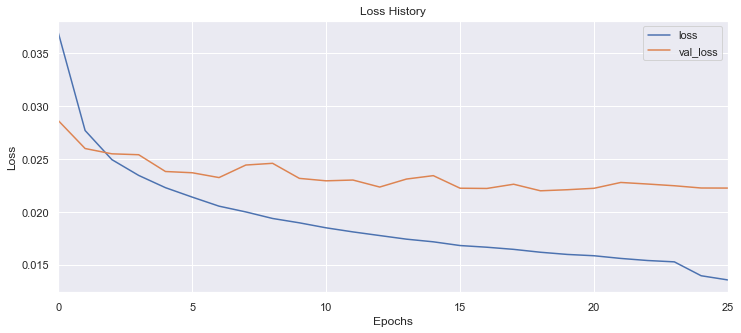

time: 224 ms


In [226]:
summary = pd.DataFrame(history.history)

ax = summary[['loss', 'val_loss']].plot(figsize=(12, 5), title='Loss History')
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

# ax = summary[['acc', 'val_acc']].plot(figsize=(12, 5), title='Acc History')
# ax.set_xlabel('Epochs');
# ax.set_ylabel('acc');

In [229]:
y_pred = predict_scores(devtest_sequences, model, score_scaler)
# cat_pred = model.predict_classes(devtest_sequences)
# y_pred = cat_pred + 1

time: 28.1 s


AUROC: 0.708
MCC: 0.470
              precision    recall  f1-score   support

           1       0.83      0.39      0.53     11749
           2       0.29      0.49      0.37      6701
           3       0.39      0.42      0.40      9611
           4       0.36      0.37      0.37     18145
           5       0.87      0.88      0.87     81696

    accuracy                           0.71    127902
   macro avg       0.55      0.51      0.51    127902
weighted avg       0.73      0.71      0.71    127902



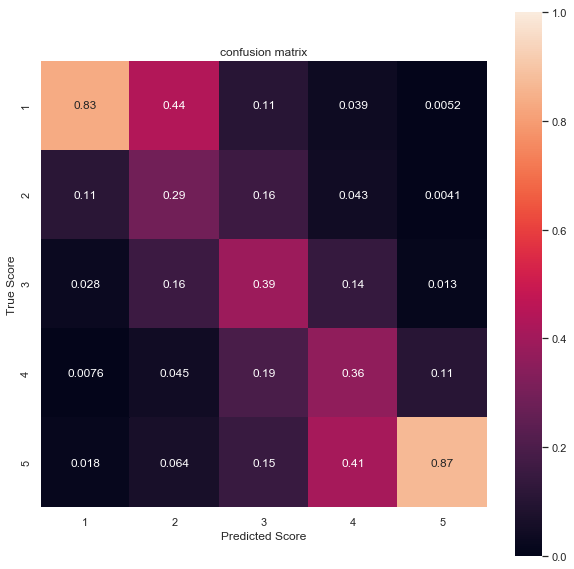

time: 741 ms


In [230]:
report = evaluate_prediction(scores_devtest, y_pred)


In [210]:
report_label = model.name
report_path = REPORTS_DIR / f'{report_label}.json'
if report_path.exists():
    overwrite = input(f'overwrite {report_path}? (Y/N)')
    if overwrite == 'Y':
        save_report(report, REPORTS_DIR, label=report_label)
else:
    save_report(report, REPORTS_DIR, label=report_label)

overwrite ../reports/conv1d-dnn-softmax.json? (Y/N) Y


time: 1.55 s
